## Week 11-12 Visual odometry

Visual odometry/ motion estimation from cameras, using the 2D-3D algorithm. Will estimate E-matrices, triangulate 3D landmarks and use PnP to fix poses to positions.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import utilis

Load the camera matrix with \
K = np.loadtxt('K.txt') \
Load the first three images \
(000001.png, 000002.png, 000003.png) into Python as im0, im1 and
im2

[[3117    0 1501]
 [   0 3117  984]
 [   0    0    1]]


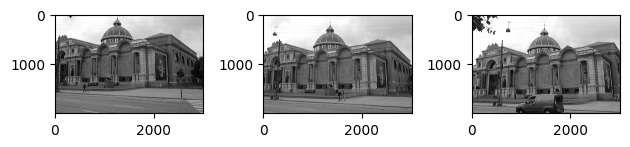

In [3]:
K = np.loadtxt('ex_11_Visual_Odometry/K.txt')
print(np.int16(K))


im0 = cv2.imread('ex_11_Visual_Odometry/sequence/000001.png')[:,:,::-1]
im1 = cv2.imread('ex_11_Visual_Odometry/sequence/000002.png')[:,:,::-1]
im2 = cv2.imread('ex_11_Visual_Odometry/sequence/000003.png')[:,:,::-1]

fig, axs = plt.subplots(1, 3)
axs[0].imshow(im0)
axs[1].imshow(im1)
axs[2].imshow(im2)
plt.tight_layout()
plt.show()

#### Exercise 11.1 SIFT features and matching

Find SIFT keypoints (kp0, kp1, kp2) in all three images and compute their corresponding descriptors (des0, des1, des2).\
(For speed reasons, you can limit the number of SIFT features to 2000.)

Convert the features to numpy arrays of 2D points\
```kp = np.array([k.pt for k in kp])```

Match the SIFT features between im0 and im1 (matches01), and between im1 and im2 (matches12).\
Convert the matches to numpy arrays of the indices\
```matches = np.array([(m.queryIdx, m.trainIdx) for m in matches]).```

In [4]:
#SIFT keypoints and their corresponding descriptors
def get_all_sift(gray, nfeatures=1999):
    """
    Get stuff
    """
    sift = cv2.SIFT_create(nfeatures=nfeatures) 
                                
    kp, desc = sift.detectAndCompute(gray, None) #Keypoints and descriptors

    point = np.array([k.pt for k in kp]).astype(np.int32)
    
    return point, kp, desc

In [5]:
point0, kp0, des0 = get_all_sift(im0)
point1, kp1, des1 = get_all_sift(im1)
point2, kp2, des2 = get_all_sift(im2)
point0.shape, point1.shape, point2.shape

((1999, 2), (1999, 2), (1999, 2))

In [6]:
#Match the SIFT features between images
def match_sift(des1, des2, KNN_matcher=False):
    """
    Match stuff
    """
    bf = cv2.BFMatcher() #crossCheck=True
    if KNN_matcher:
        knn_matches = bf.knnMatch(des1, des2, k=2)
        # Ratio test!
        ratio_matches = []
        for m,n in knn_matches:
            if m.distance < 0.75*n.distance:
                ratio_matches.append(m)
        
        # Return the keypoint indexes of matches 
        return np.array([(m.queryIdx, m.trainIdx) for m in ratio_matches])
    else:
        all_matches = bf.match(des1, des2)
        return np.array([(m.queryIdx, m.trainIdx) for m in all_matches])
    

In [7]:
matches01= match_sift(des0, des1, KNN_matcher=False) #, KNN_matcher=True) 
matches12 = match_sift(des1, des2, KNN_matcher=False) #, KNN_matcher=True) 
matches01, matches12.shape

(array([[   0, 1593],
        [   1, 1197],
        [   2, 1690],
        ...,
        [1996, 1808],
        [1997, 1899],
        [1998, 1955]]),
 (1999, 2))

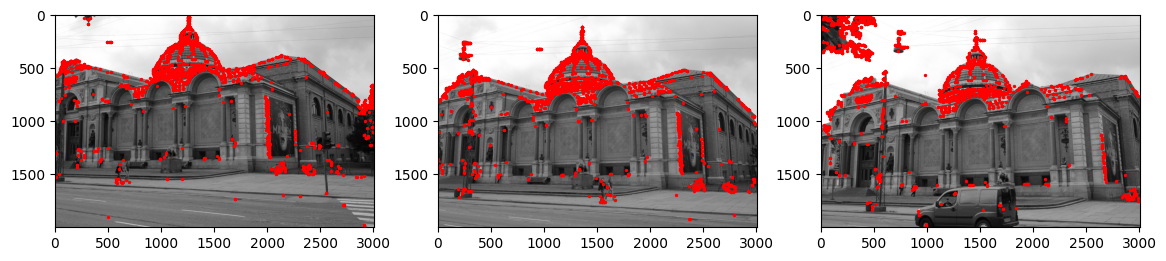

In [8]:
## Look at some images

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
axs[0].imshow(im0, cmap="gray")
axs[0].scatter(point0[:, 0], point0[:, 1], s=2, c="r")
axs[1].imshow(im1, cmap="gray")
axs[1].scatter(point1[:, 0], point1[:, 1], s=2, c="r")
axs[2].imshow(im2, cmap="gray")
axs[2].scatter(point2[:, 0], point2[:, 1], s=2, c="r");

#### EX 11.2 Essential matrix

Estimate the essential matrix between im0 and im1 with RANSAC. You can use the OpenCV 
function cv2.findEssentialMat to do this. \
The mask returned by this function indicates which
of the matches are inliers.

***NB*** The function expects the points in the correct/ matching order.

In [9]:
E01, Emask01 = cv2.findEssentialMat(point0[matches01[:, 0], :], point1[matches01[:, 1], :], K, method=cv2.RANSAC,
                           #prob=0.999, threshold=..., maxIters=...
                           )
E12, Emask12 = cv2.findEssentialMat(point1[matches12[:, 0], :], point2[matches12[:, 1], :], K, method=cv2.RANSAC,
                           #prob=0.999, threshold=..., maxIters=...
                           )
print(len(np.where(Emask01>0)[0]))
print(Emask01.shape)
print(E12)
print(Emask01.astype(int).sum())
# print(recover_mask1.astype(int).sum())
print(sum(Emask01))

563
(1999, 1)
[[-0.00226488  0.40951294 -0.07497906]
 [-0.40808879  0.01501471 -0.57063849]
 [ 0.08426944  0.57174406  0.01701056]]
563
[51]


Estimation: *cv2.findEssentialMat* is used to estimate the Essential matrix from matched points (point0 and point1 from matches01). This function also returns a mask (Emask01) that identifies inliers, which are the matches that fit the estimated model well.

Decompose the essential matrix and find the correct relative pose (R1, t1). For this we can again \
use an OpenCV function namely cv2.recoverPose. The mask returned by cv2.recoverPose indicates which of the matches/**POINTS** are inliers, that lie in front of both cameras.
- Choose the best of the 4 different options: The one where points are in front of cameras

In [10]:
_, R01, t01, mask01 = cv2.recoverPose(E01, point0[matches01[:, 0], :], point1[matches01[:, 1], :], K)
_, R12, t12, mask12 = cv2.recoverPose(E12, point1[matches12[:, 0], :], point2[matches12[:, 1], :], K)

print(K)
len(np.where(mask12>0)[0])
print(Emask01.astype(int).sum())
# print(recover_mask1.astype(int).sum())
print(sum(mask01))

[[3.1174740e+03 0.0000000e+00 1.5019408e+03]
 [0.0000000e+00 3.1174740e+03 9.8476840e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
563
[118]


Decomposition: *cv2.recoverPose* is used to decompose the Essential matrix into a rotation matrix (R01, R12) and a translation vector (t01, t12). It also returns a mask that identifies which of these inliers also lie in front of both cameras.

Combine this mask with the mask from cv2.findEssentialMat, to get the matches that are both \
1inliers and lie in front of both cameras. Remove the matches that are not inliers from matches01, \
so that only contains the inliers.

In [11]:
matches01_filtered = matches01[np.where(Emask01>0)[0]]
matches12_filtered = matches12[np.where(Emask12>0)[0]]

len(matches01), len(matches01_filtered)

(1999, 563)

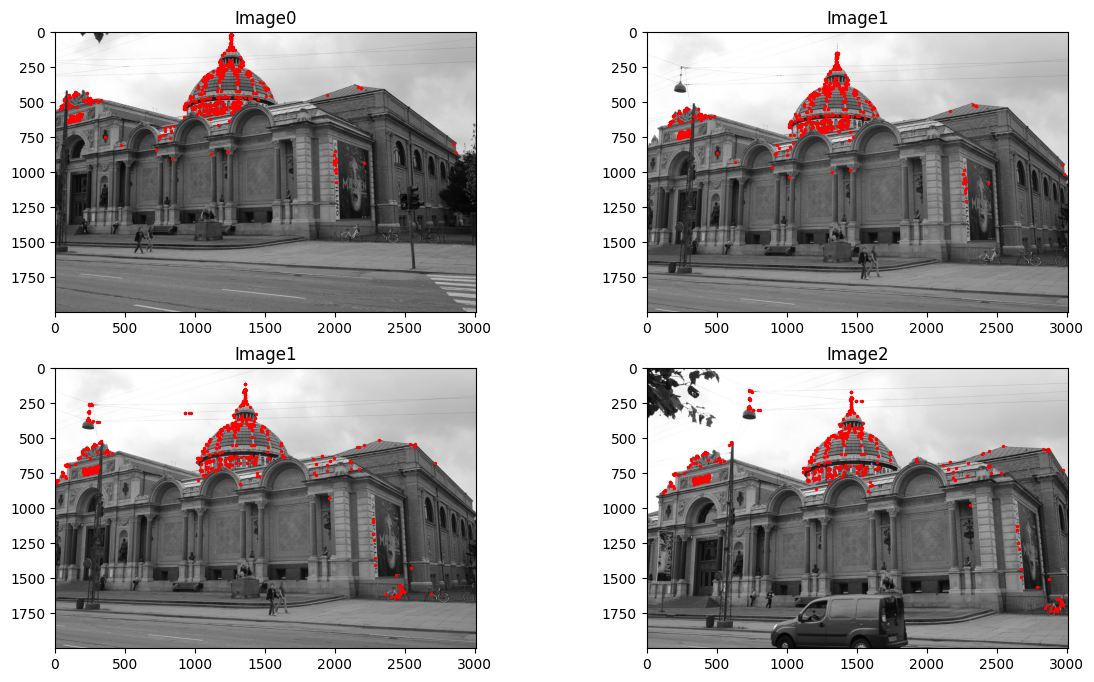

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
axs[0, 0].imshow(im0, cmap="gray")
axs[0, 0].scatter(point0[matches01_filtered[:, 0], 0], point0[matches01_filtered[:, 0], 1], s=2, c="r")
axs[0, 0].set_title("Image0")
axs[0, 1].imshow(im1, cmap="gray")
axs[0, 1].scatter(point1[matches01_filtered[:, 1], 0], point1[matches01_filtered[:, 1], 1], s=2, c="r")
axs[0, 1].set_title("Image1")
axs[1, 0].imshow(im1, cmap="gray")
axs[1, 0].scatter(point1[matches12_filtered[:, 0], 0], point1[matches12_filtered[:, 0], 1], s=2, c="r")
axs[1, 0].set_title("Image1")
axs[1, 1].imshow(im2, cmap="gray")
axs[1, 1].scatter(point2[matches12_filtered[:, 1], 0], point2[matches12_filtered[:, 1], 1], s=2, c="r")
axs[1, 1].set_title("Image2");

***NB!*** Using KNN ratio test to filter matches produced better results than using the recoverPose output. BUT! Fewer points - and we are doing RANSAC, so more is merrier.

#### 11.3 Track across all images

Use matches01 and matches12 and find the subset of matches such that we can match features \
all the way from image 0 to image 2. In other words, create three lists such that points0[i], \
points1[i], and points2[i] are the 2D locations of the same point in the corresponding images. \
For this you can use \
_, idx01, idx12 = np.intersect1d(matches01[:,1], matches12[:,0], return_indices=True)

In [13]:
#Find the intersection of two arrays.
# So, in this case where will matches between two first images, continue into the third
_, idx01, idx12 = np.intersect1d(matches01_filtered[:,1], matches12_filtered[:,0], return_indices=True)

#Return the sorted, unique values that are in both of the input arrays.
# So, idx01: indexes of matches in matches01_filtered that were also matches in image 2.as_integer_ratio
# And idx12 is also the valid matches in matches12_filtered 

In [14]:
# Extracting the valid matches - that go throughout the images
validmatch01 = matches01_filtered[idx01, :]
validmatch12 = matches12_filtered[idx12, :]

# Extract the points belonging to the valid matches
val0_idx = validmatch01[:, 0]
val1_idx = validmatch01[:, 1]
val2_idx = validmatch12[:, 1]



trans0 = point0[val0_idx, :].astype(np.float32)
trans1 = point1[val1_idx, :].astype(np.float32)
trans2 = point2[val2_idx, :].astype(np.float32)

print(trans0)

[[1289.  497.]
 [1211.  276.]
 [  95.  626.]
 [1238.  229.]
 [  98.  640.]
 [  96.  506.]
 [  98.  624.]
 [1236.  242.]
 [ 178.  585.]
 [ 178.  585.]
 [ 930.  518.]
 [ 123.  612.]
 [  97.  466.]
 [ 123.  621.]
 [1237.  125.]
 [ 266.  490.]
 [1218.  264.]
 [ 101.  637.]
 [ 929.  513.]
 [1292.  418.]
 [1292.  418.]
 [ 102.  625.]
 [1292.  494.]
 [ 102.  625.]
 [ 120.  525.]
 [ 174.  624.]
 [ 119.  620.]
 [ 923.  537.]
 [ 105.  613.]
 [1297.  290.]
 [1297.  537.]
 [1300.  306.]
 [1300.  306.]
 [ 106.  463.]
 [1230.  129.]
 [ 116.  600.]
 [ 116.  622.]
 [1299.  357.]
 [1299.  357.]
 [ 110.  638.]
 [ 115.  611.]
 [1307.  267.]
 [ 937.  518.]
 [1289.  511.]
 [1291.  265.]
 [1044.  584.]
 [1288.  282.]
 [1314.  268.]
 [1365.  299.]
 [ 967.  469.]
 [1316.  274.]
 [1316.  274.]
 [1324.  242.]
 [ 982.  534.]
 [ 982.  534.]
 [ 983.  549.]
 [ 984.  542.]
 [ 985.  459.]
 [ 988.  537.]
 [1314.  541.]
 [1281.  289.]
 [1316.  418.]
 [1316.  418.]
 [ 235.  472.]
 [1002.  541.]
 [1004.  524.]
 [1374.  2

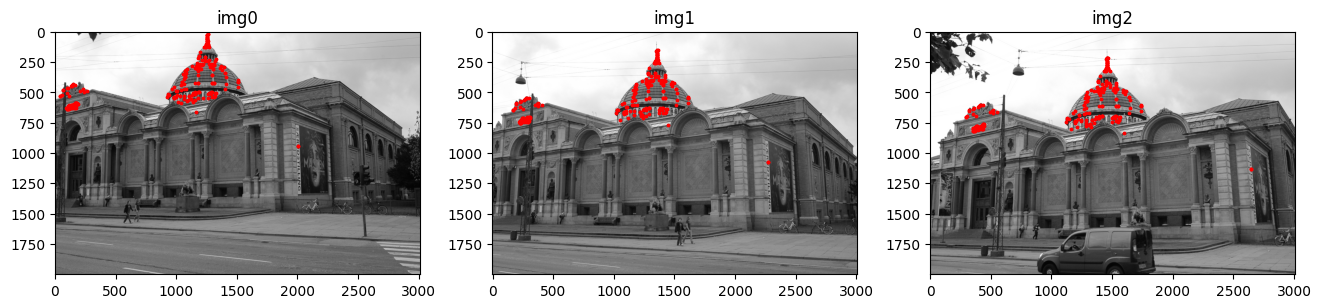

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
axs[0].imshow(im0, cmap="gray")
axs[0].scatter(trans0[:, 0], trans0[:, 1], s=3, c="r")
axs[0].set_title("img0")
axs[1].imshow(im1, cmap="gray")
axs[1].scatter(trans1[:, 0], trans1[:, 1], s=3, c="r")
axs[1].set_title("img1")
axs[2].imshow(im2, cmap="gray")
axs[2].scatter(trans2[:, 0], trans2[:, 1], s=3, c="r")
axs[2].set_title("img2");

#### 11.4 Triangulate

For the points that have been tracked through all three images, use the 2D positions in image 0\
and 1 to triangulate the points in 3D (Q). Using the 2D positions in image 2, estimate the pose\
of image 2 with RANSAC. Use cv2.solvePnPRansac to do this. As the lens distortion is already\
corrected, you can set ```distCoeffs=np.zeros(5)```.

Visualize the 3D points that are also inliers for solvePnPRansac.
```
fig = plt.figure()
ax = fig.add_subplot(projection=’3d’)
ax.scatter(*Q[inliers.flatten()])
```
Also plot the position of the cameras. Recall that the position of the camera is not the translation.
How do you find the position?

In [16]:
distCoeffs=np.zeros(5) 
# Projection matrix using 
P0 = K@np.hstack((np.eye(3), np.zeros((3,1))))
P1 = K@np.hstack((R01, t01))
print((trans0.T).shape)

(2, 232)


In [ ]:
#To triangulate I need the 2 projection matrix and 
#the list of 2D points of the images found with SIFT
Q = cv2.triangulatePoints(P0, P1, trans0.T, trans1.T)
Q = Q[:-1] / Q[-1]
Q.shape

array([[-1.80150843e+00, -2.63774467e+00, -7.77212143e+00,
        -2.56173801e+00, -7.72878218e+00, -7.80269814e+00,
        -7.69496441e+00, -2.54643250e+00, -1.53662281e+01,
        -1.53662281e+01, -5.32496500e+00, -7.49243164e+00,
        -7.87409687e+00, -7.54026651e+00, -2.60286236e+00,
        -6.44188976e+00, -2.60907078e+00, -7.73799372e+00,
        -5.48769951e+00, -1.79055345e+00, -1.79055345e+00,
        -7.67794895e+00, -1.77506948e+00, -7.67794895e+00,
        -7.61248636e+00, -2.35722561e+01, -7.48990250e+00,
        -5.68183851e+00, -7.69406176e+00, -1.85513163e+00,
        -1.74826276e+00, -1.80553377e+00, -1.80553377e+00,
        -7.77389717e+00, -2.74187803e+00, -7.59894562e+00,
        -7.56401777e+00, -1.76571286e+00, -1.76571286e+00,
        -7.61930704e+00, -7.59199858e+00, -1.81428885e+00,
        -5.20058298e+00, -1.81735992e+00, -1.93875539e+00,
         3.52580490e+01, -1.93267715e+00, -1.75015223e+00,
        -1.26357603e+00, -4.93311882e+00, -1.69270551e+0

Using the 2D positions in image 2, estimate the pose\
of image 2 with RANSAC. Use cv2.solvePnPRansac to do this.

In [18]:
# Get rvec, tvec of the image 2
_, rvec, tvec, inliers = cv2.solvePnPRansac(Q.T, trans2, K, None)
rot = cv2.Rodrigues(rvec)[0]
# tvec = -rot.T.dot(tvec)  # coordinate transformation, from camera to world.

In [19]:
t0 = np.array([[0, 0, 0]]).T
p0x, p0y, p0z = t0
p1x, p1y, p1z = -R01.T @ t01
p2x, p2y, p2z = -rot.T @ tvec

print(p1x, p1y, p1z)
print(p2x, p2y, p2z)

[-0.80641229] [0.0506108] [0.58918398]
[-1.71197193] [0.09556953] [1.50013493]


In [20]:
Q.shape, inliers.shape

((3, 232), (205, 1))

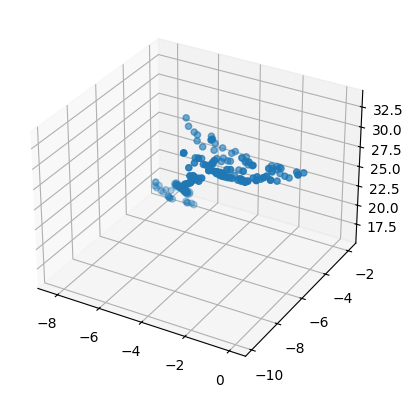

In [21]:
# Visualize 3D points that are also inliers for solveRansac
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(Q[0, inliers], Q[1, inliers], Q[2, inliers])

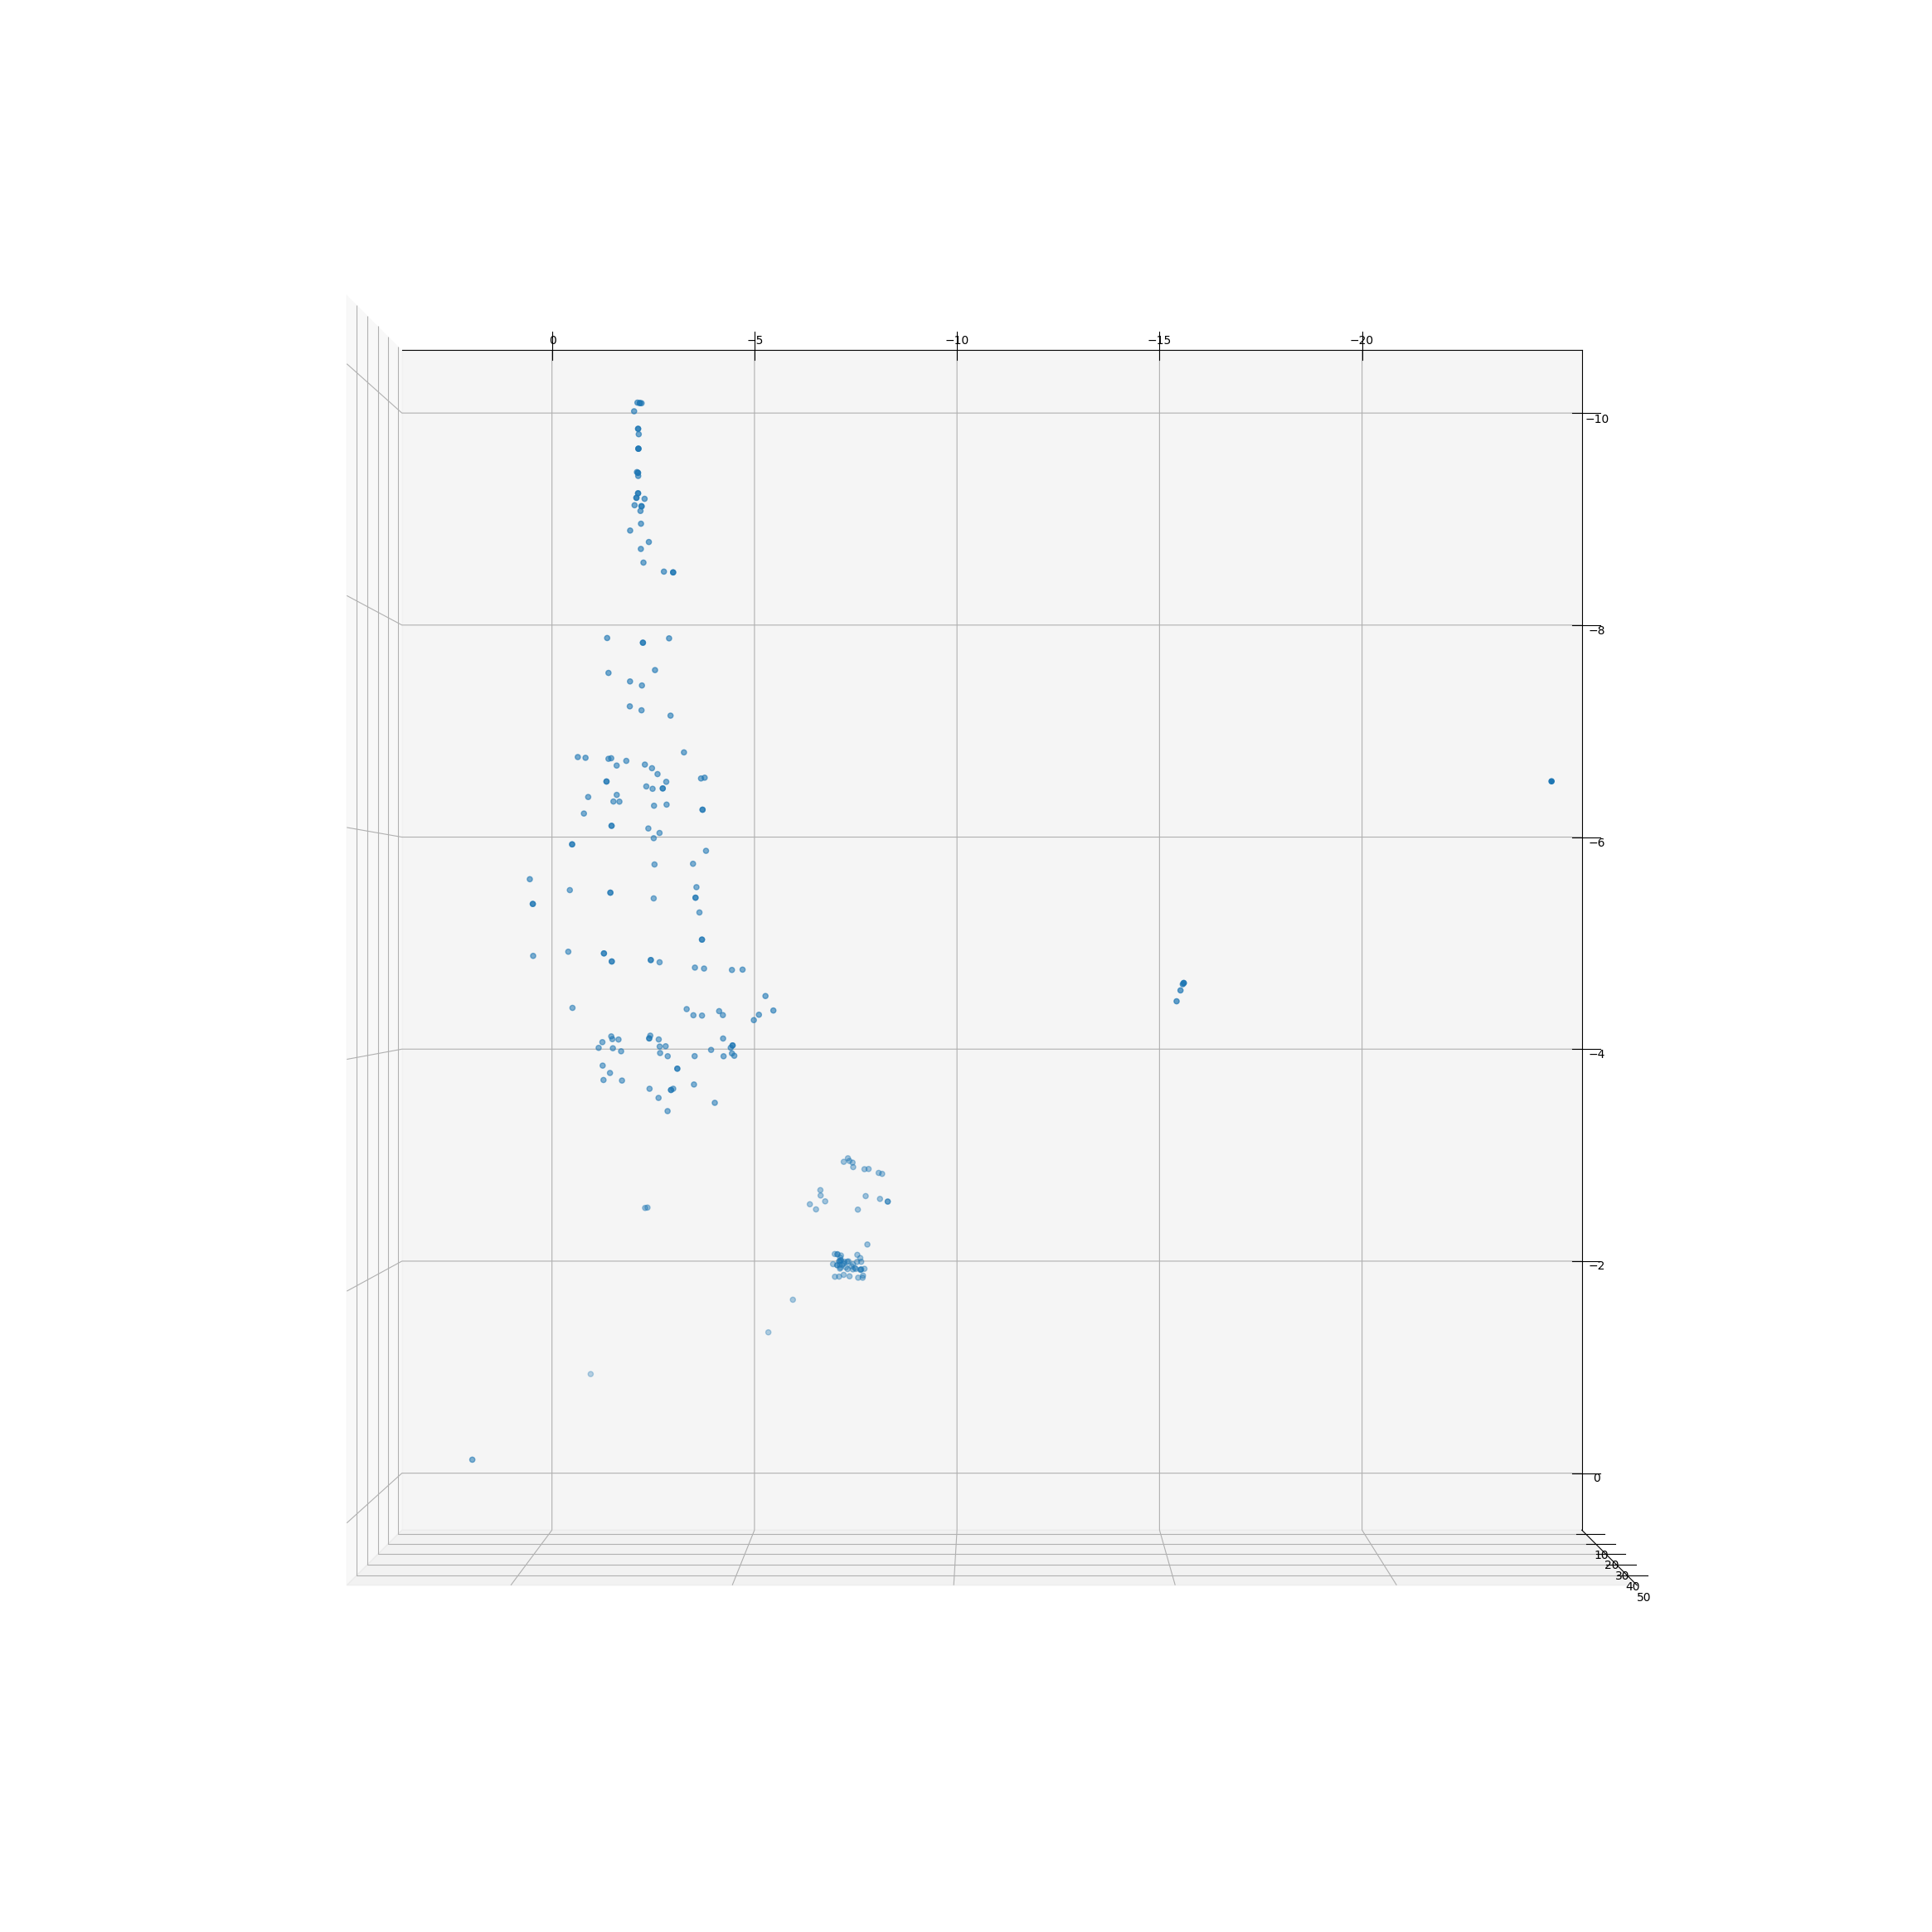

In [22]:
def filter_points(Q, tx=100, ty=100, tz=100):
    Q = Q[:, np.abs(Q[0, :]) < tx]
    Q = Q[:, np.abs(Q[1, :]) < ty]
    Q = Q[:, np.abs(Q[2, :]) < tz]
    return Q

Q_filter = filter_points(Q)

fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(projection="3d")
ax.scatter(Q_filter[0, :], Q_filter[1, :], Q_filter[2, :]);
ax.view_init(90, 90)

#### Exercise 11.5
Iterate through all images in the folder, repeating the steps in Exercises 11.3 and 11.4 for the 
previous three images each time. \
Visualize all the 3D points and camera positions. Does it look correct?

In [23]:
import glob
ext = ['png', 'jpg', 'gif'] # filetypes
imdir = "ex_11_Visual_Odometry/sequence/"
files = []
[files.extend(glob.glob(imdir + '*.' + e)) for e in ext]
images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_RGB2GRAY) for file in files]

# Look at some images
im0, im1, im2 = images[0], images[1], images[2]

In [24]:
##########################
### FIRST THREE IMAGES ###
##########################

# Extract keypoints
point0, kp0, des0 = get_all_sift(images[0])
point1, kp1, des1 = get_all_sift(images[1])
point2, kp2, des2 = get_all_sift(images[2])
# Match keypoints
matches01 = match_sift(des0, des1) #, KNN_matcher=True) 
matches12 = match_sift(des1, des2) #, KNN_matcher=True) 
matches01.shape, matches12.shape

# Recover essential matries
E01, Emask01 = cv2.findEssentialMat(point0[matches01[:, 0], :], point1[matches01[:, 1], :], K, method=cv2.RANSAC,
                        #prob=0.999, threshold=..., maxIters=...
                        )
E12, Emask12 = cv2.findEssentialMat(point1[matches12[:, 0], :], point2[matches12[:, 1], :], K, method=cv2.RANSAC,
                        #prob=0.999, threshold=..., maxIters=...
                        )

# Recover camera poses
_, R01, t01, _ = cv2.recoverPose(E01, point0[matches01[:, 0], :], point1[matches01[:, 1], :], K)
#_, R12, t12, _ = cv2.recoverPose(E12, point1[matches12[:, 0], :], point2[matches12[:, 1], :], K)

# Filter matches based on inliers
matches01_filtered = matches01[np.where(Emask01>0)[0]]
matches12_filtered = matches12[np.where(Emask12>0)[0]]

# Intersection of matches
_, idx01, idx12 = np.intersect1d(matches01_filtered[:,1], matches12_filtered[:,0], return_indices=True)

# Extracting the valid matches - that go throughout the images
validmatch01 = matches01_filtered[idx01, :]
validmatch12 = matches12_filtered[idx12, :]

# Extract the points belonging to the valid matches
val0_idx = validmatch01[:, 0]
val1_idx = validmatch01[:, 1]
val2_idx = validmatch12[:, 1]

#
trans0 = point0[val0_idx, :].astype(np.float32)
trans1 = point1[val1_idx, :].astype(np.float32)
trans2 = point2[val2_idx, :].astype(np.float32)
valid_des_2 = des2[val2_idx, :]

# Projection matrix using 
P0 = K@np.hstack((np.eye(3), np.zeros((3,1))))
P1 = K@np.hstack((R01, t01))

# Triangulate points to world coordinates
Q = cv2.triangulatePoints(P0, P1, trans0.T, trans1.T)
Q = Q[:-1] / Q[-1]

# PnP to get position of object
_, rvec, tvec, inliers = cv2.solvePnPRansac(Q.T, trans2, K, None)
rot, _ = cv2.Rodrigues(rvec)
#tvec = -rot.T.dot(tvec) !!!!
P2 = K@np.hstack((rot, tvec))

print(inliers.shape, Q.T.shape, trans2.shape, valid_des_2.shape)

(205, 1) (232, 3) (232, 2) (232, 128)


In [25]:
##############################
### The rest of the images ###
##############################
prev_des = valid_des_2.copy()           # Only keep valid
prev_points = trans2.copy()             # Only keep valid   
P_prev = P2.copy()                      # World-coordinate pose
Q_prev = Q.copy()                       # Landmarks
prev_frame = images[2]
#prev_prev_frame = images[2]             # 11.3 style?
#######  Book-keeping ########
all_Qs = [Q]
all_ts = [tvec]
all_Rs = [rot]

for i in tqdm(range(3, len(images))):
#for i in range(3, len(images)):
    """
    Loopy doopy.
    """
    current_frame = images[i]
    # Extract keypoints
    new_points, new_kp, new_des = get_all_sift(current_frame)
    
    # Match keypoints
    new_matches = match_sift(prev_des, new_des, KNN_matcher=True)
    print("New_ matches:", new_matches.shape)

    """ use 11.3 to get transitive points
    _, idx01, idx12 = np.intersect1d(prev_matches[:,1], new_matches[:,0], return_indices=True)

    # Extracting the valid matches - that go throughout the images
    trans_matches = new_matches[idx12, :]
    print(trans_matches.shape, new_matches.shape)


    # Extract the points belonging to the valid matches
    prev_idx = trans_matches[:, 0]
    new_idx = trans_matches[:, 1]
    """
    
    """ Or... Simple approach """
    # Extract the points belonging to the valid matches!
    try:
        prev_idx = new_matches[:, 0]
        new_idx = new_matches[:, 1]
    except IndexError:
        print("Found no matches from previous frame")
        break
    
    # Extract "transitive" points and cast to float.
    Q_prev_trans = Q_prev[:, prev_idx] # Also remove Qs not found
    new_trans = new_points[new_idx, :].astype(np.float32)
    
    
    print("Landmarks filtered out:", Q_prev.shape, Q_prev_trans.shape)


    # PnP to get position
    _, rvec, tvec, inliers = cv2.solvePnPRansac(Q_prev_trans.T, new_trans, K, None)
    rot, _ = cv2.Rodrigues(rvec)
    #tvec = -rot.T.dot(tvec) #!!!
    P_new = K@np.hstack((rot, tvec)) 

    """ New approach: slow but steady?
        - Repeat al of 11.1-11.4, but using P_new.
    """
    # Overwrite the "prev". New triangulation time!
    # Now that we have P_new, we don't mneed the previous data anymore
    prev_points, prev_kp, prev_des = get_all_sift(prev_frame)
    
    # Match keypoints
    triang_matches = match_sift(prev_des, new_des)
    
    # Filter these matches somehow... Use Essential matrix mapping??
    _, triang_mask = cv2.findEssentialMat(prev_points[triang_matches[:, 0], :], new_points[triang_matches[:, 1], :], K, method=cv2.RANSAC)
    triang_matches_filtered = triang_matches[np.where(triang_mask>0)[0]]
    prev_idx = triang_matches_filtered[:, 0]
    new_idx = triang_matches_filtered[:, 1]

    # Filter out using indexes
    prev_trans = prev_points[prev_idx, :].astype(np.float32)
    new_trans = new_points[new_idx, :].astype(np.float32)
    valid_des = new_des[new_idx, :]

    # Projection matrix using 
    Q_new = cv2.triangulatePoints(P_prev, P_new, prev_trans.T, new_trans.T)
    Q_new = Q_new[:-1] / Q_new[-1]

    # TODO: step 11.3 - transitive relation not intact. Only for two and two

    ############################################################
    ####################### Book-keeping #######################
    ############################################################
    all_Qs.append(Q_new)
    all_ts.append(tvec)
    all_Rs.append(rot)
    #
    prev_des = valid_des.copy()         # Only valid
    prev_points = new_trans.copy()      # Only valid
    P_prev = P_new.copy()               # World-coordinate pose
    Q_prev = Q_new.copy()               # Landmarks
    prev_frame = current_frame.copy()   # Keep frame
    #



  0%|          | 0/17 [00:00<?, ?it/s]

New_ matches: (129, 2)
Landmarks filtered out: (3, 232) (3, 129)


  6%|▌         | 1/17 [00:01<00:24,  1.55s/it]

New_ matches: (231, 2)
Landmarks filtered out: (3, 382) (3, 231)


 12%|█▏        | 2/17 [00:03<00:22,  1.53s/it]

New_ matches: (451, 2)
Landmarks filtered out: (3, 903) (3, 451)


 18%|█▊        | 3/17 [00:04<00:23,  1.71s/it]

New_ matches: (335, 2)
Landmarks filtered out: (3, 625) (3, 335)


 24%|██▎       | 4/17 [00:06<00:21,  1.67s/it]

New_ matches: (350, 2)
Landmarks filtered out: (3, 580) (3, 350)


 29%|██▉       | 5/17 [00:08<00:19,  1.66s/it]

New_ matches: (285, 2)
Landmarks filtered out: (3, 599) (3, 285)


 35%|███▌      | 6/17 [00:09<00:18,  1.65s/it]

New_ matches: (201, 2)
Landmarks filtered out: (3, 417) (3, 201)


 41%|████      | 7/17 [00:11<00:16,  1.66s/it]

New_ matches: (238, 2)
Landmarks filtered out: (3, 521) (3, 238)


 47%|████▋     | 8/17 [00:13<00:14,  1.63s/it]

New_ matches: (175, 2)
Landmarks filtered out: (3, 353) (3, 175)


 53%|█████▎    | 9/17 [00:14<00:13,  1.63s/it]

New_ matches: (172, 2)
Landmarks filtered out: (3, 356) (3, 172)


 59%|█████▉    | 10/17 [00:16<00:11,  1.61s/it]

New_ matches: (215, 2)
Landmarks filtered out: (3, 642) (3, 215)


 65%|██████▍   | 11/17 [00:17<00:09,  1.61s/it]

New_ matches: (78, 2)
Landmarks filtered out: (3, 438) (3, 78)


 71%|███████   | 12/17 [00:19<00:08,  1.61s/it]

New_ matches: (36, 2)
Landmarks filtered out: (3, 82) (3, 36)


 76%|███████▋  | 13/17 [00:21<00:06,  1.61s/it]

New_ matches: (62, 2)
Landmarks filtered out: (3, 125) (3, 62)


 82%|████████▏ | 14/17 [00:22<00:04,  1.62s/it]

New_ matches: (52, 2)
Landmarks filtered out: (3, 475) (3, 52)


 88%|████████▊ | 15/17 [00:25<00:03,  1.68s/it]

New_ matches: (0,)
Found no matches from previous frame


In [26]:
world_translation = np.zeros((3, len(all_ts)))
for i in range(len(all_ts)):
    # Translate to world coordinates:
    rot = all_Rs[i]
    camera_t = all_ts[i]
    world_t = -rot.T.dot(camera_t)
    world_translation[:, i] = world_t[:,0]
print(world_translation.shape)
filtered_t = filter_points(world_translation)#, 15, 15, 60)
print(filtered_t.shape)

(3, 16)
(3, 16)


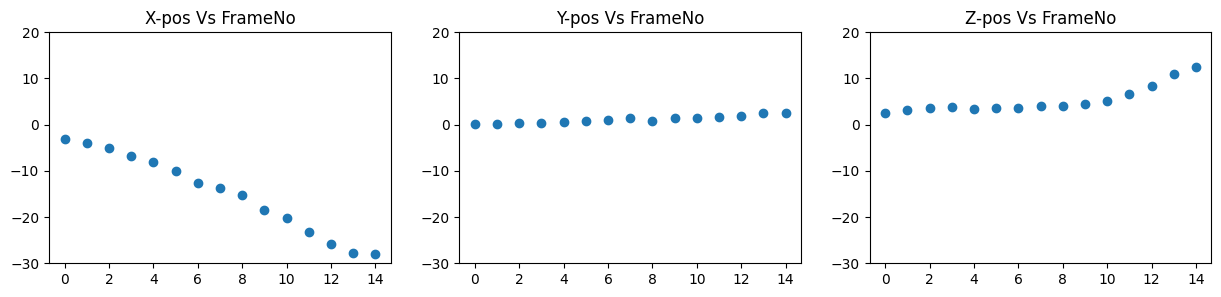

In [27]:
time = np.arange(0, len(filtered_t[0,1:]))
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
axs[0].scatter(time, filtered_t[0,1:])
axs[0].set_title("X-pos Vs FrameNo")
axs[0].set_ylim([-30, 20])
axs[1].scatter(time, filtered_t[1,1:])
axs[1].set_title("Y-pos Vs FrameNo")
axs[1].set_ylim([-30, 20])
axs[2].scatter(time, filtered_t[2,1:])
axs[2].set_title("Z-pos Vs FrameNo")
axs[2].set_ylim([-30, 20]);

16

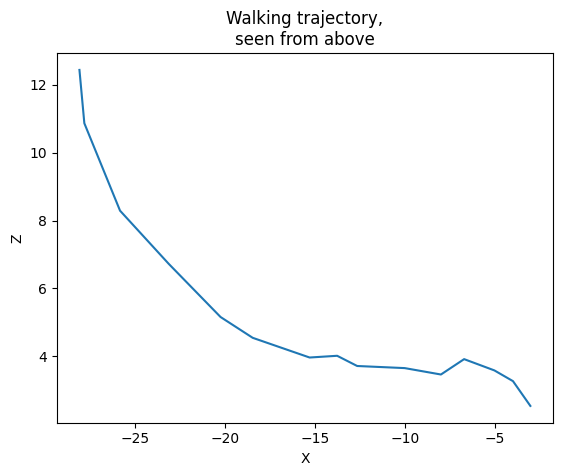

In [28]:
plt.plot(filtered_t[0,1:], filtered_t[2,1:])
plt.xlabel("X")
plt.ylabel("Z")

plt.title("Walking trajectory,\nseen from above");

len(all_Qs)

(3, 6784)
(3, 6557)


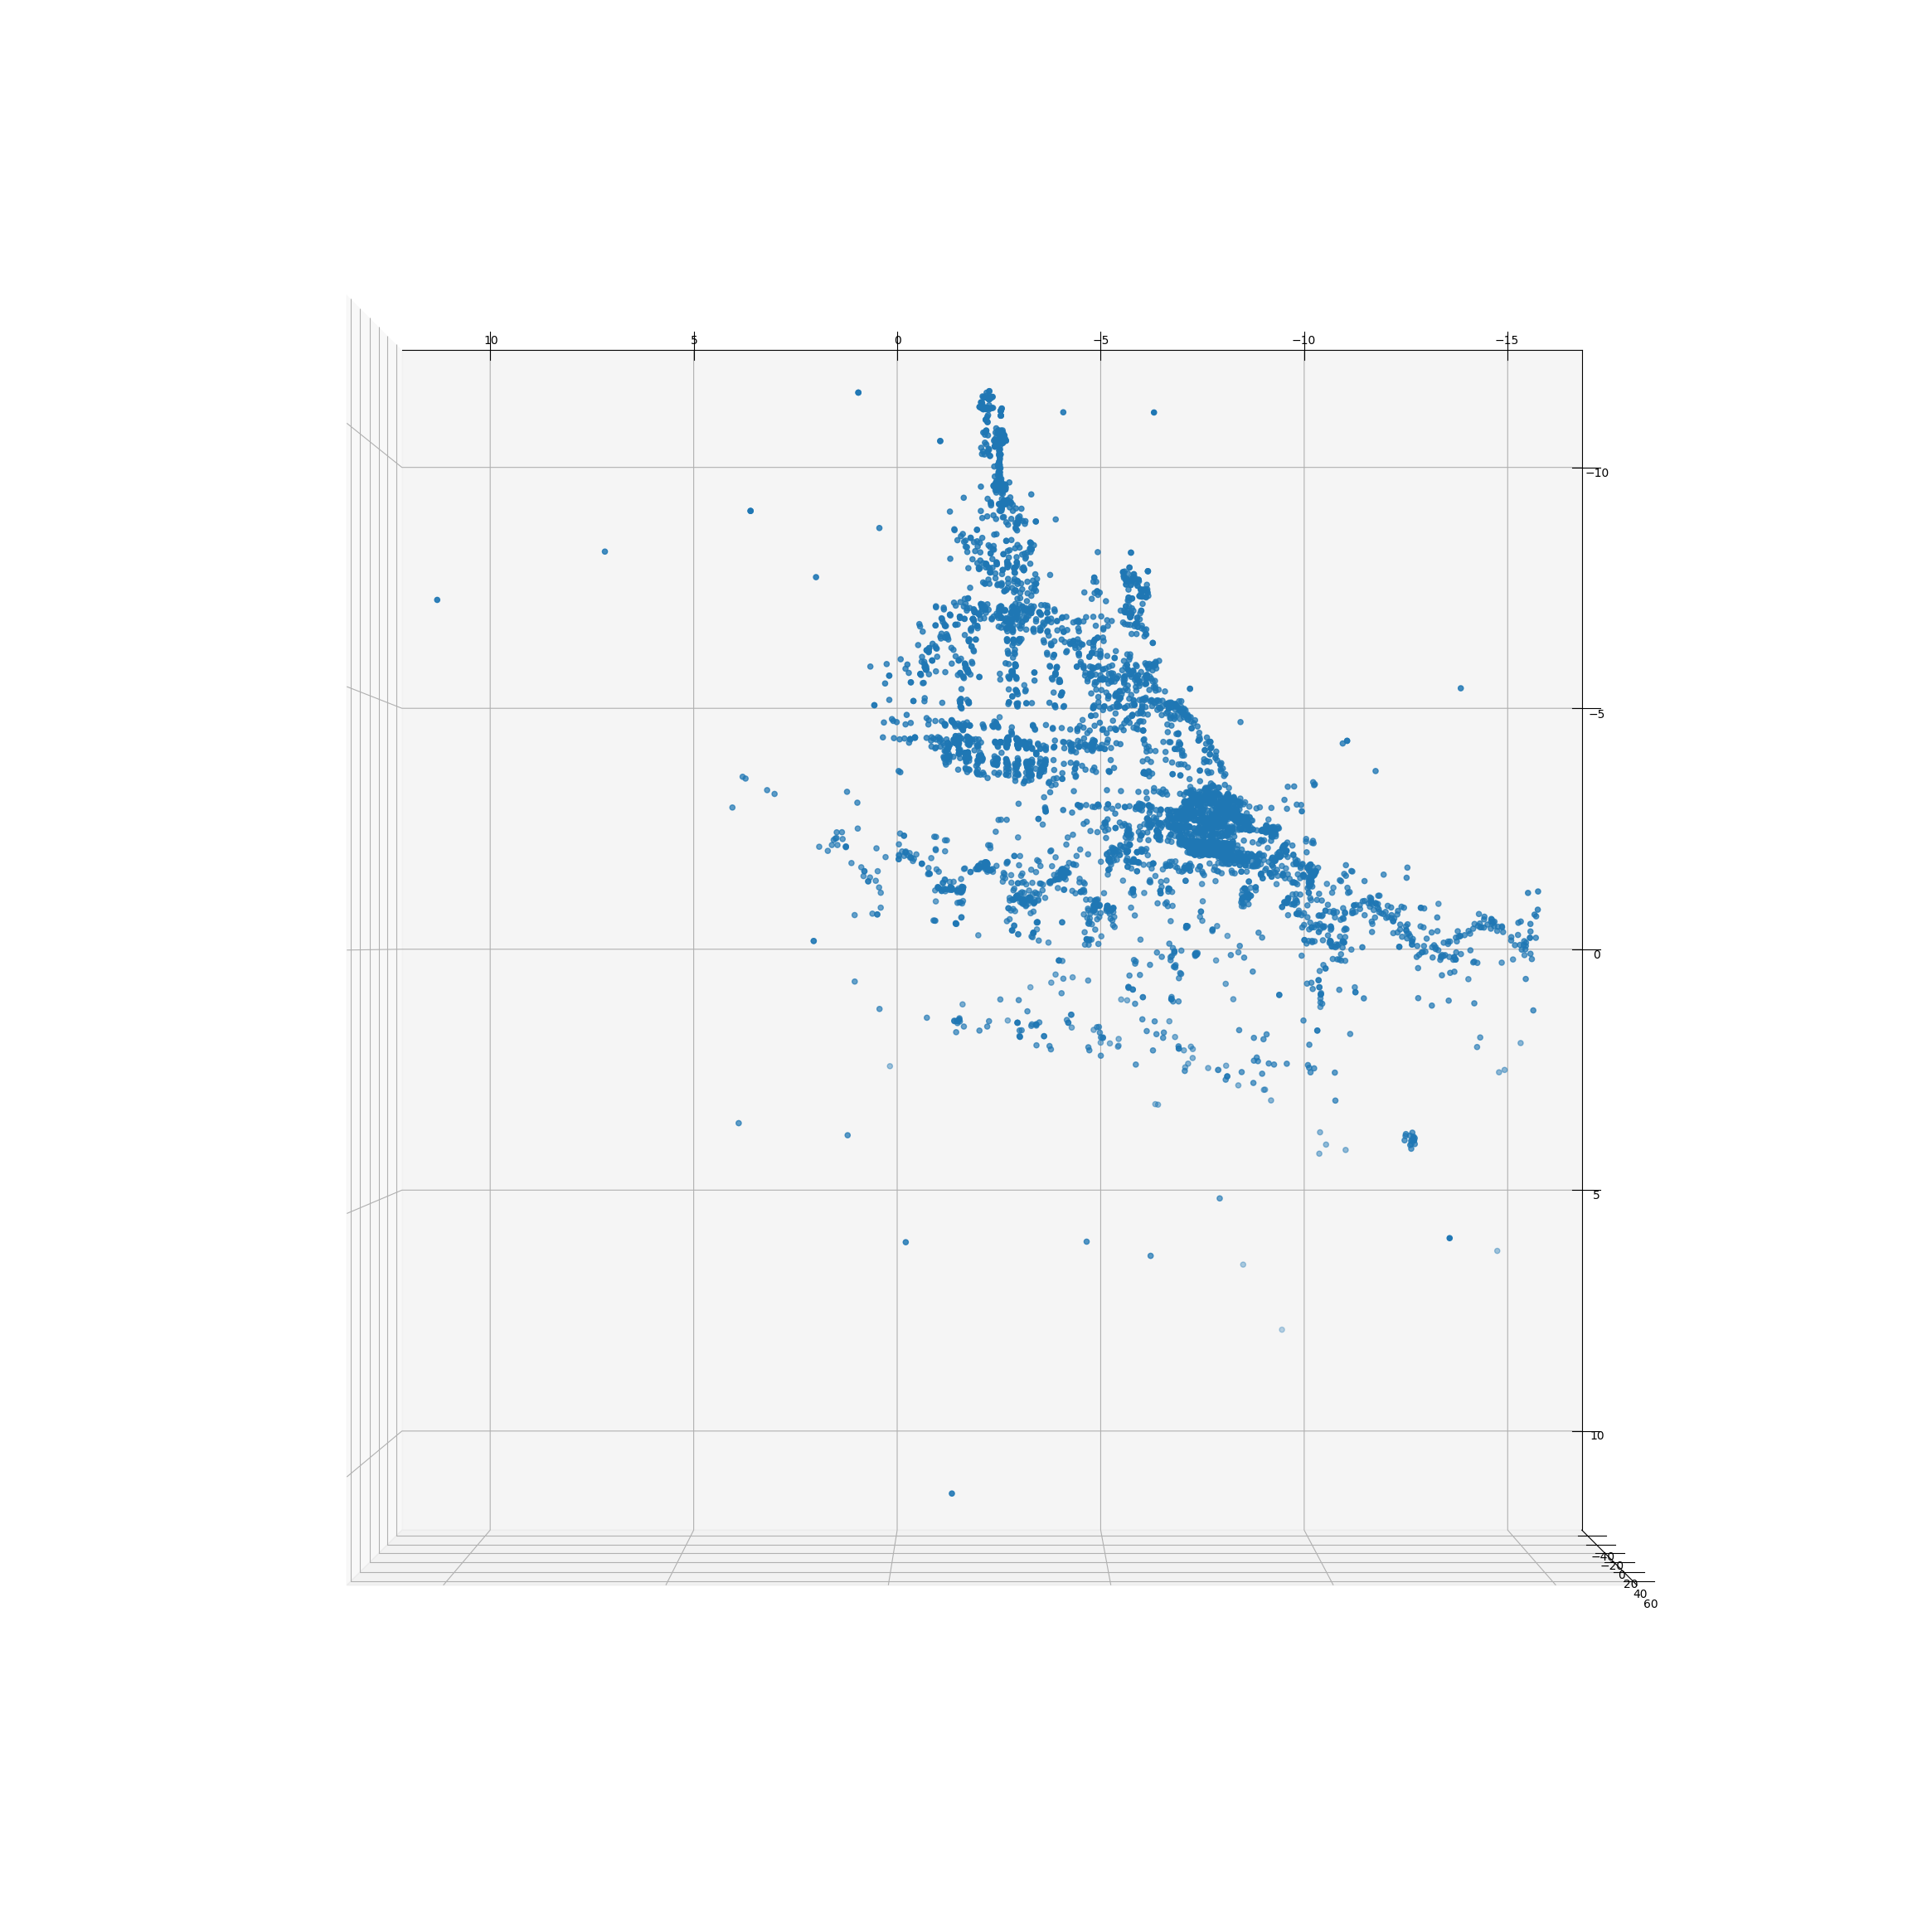

In [29]:
Qs = np.hstack(all_Qs[:])
print(Qs.shape)
Q_filter = filter_points(Qs, 15, 15, 60)
print(Q_filter.shape)

fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(projection="3d")
ax.scatter(Q_filter[0, :], Q_filter[1, :], Q_filter[2, :]);
ax.view_init(90, 90);

#### ESTIMATE CAMERA POSE FROM ESSENTIAL MATRIX


In [30]:
# Example data: pts1 and pts2 are the matched points from two consecutive images
# These should be Nx2 arrays where N is the number of matched points
pts1 = # Load or compute your matched feature points for image 1
pts2 = # Load or compute your matched feature points for image 2

# Camera intrinsic matrix K (you should have this from your camera calibration step)
K = np.array([[f, 0, cx],
              [0, f, cy],
              [0, 0, 1]])

# Find the Essential Matrix using RANSAC
E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

# Decompose the Essential Matrix to get possible rotation and translation
_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)

print("Rotation Matrix:\n", R)
print("Translation Vector:\n", t)

# You can use R and t to transform coordinates from the first camera frame to the second

SyntaxError: invalid syntax (3716905734.py, line 3)